In [272]:
from PIL import Image
import numpy as np
from numba import cuda
import time
import cv2
from google.colab.patches import cv2_imshow

def getImage(pathfile):
    image = Image.open(pathfile)

    rgb_array = np.array(image).reshape(-1, 3)

    width, height = image.size

    return rgb_array, width, height

def showImage(inPixels, width, height):
  outPixels = np.array(inPixels, dtype=np.uint8).reshape(height, width, 3)

  return Image.fromarray(outPixels)

## Gray Image

In [2]:
# Alternative appoarch
# @cuda.jit
# def convert_Rgb2Gray_cuda(inPixels, width, height, outPixels):
#     r = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
#     c = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x

#     if r < height and c < width:
#         i = r * width + c
#         gray_value = 0.299 * inPixels[3 * i] + 0.587 * inPixels[3 * i + 1] + 0.114 * inPixels[3 * i + 2]
#         outPixels[i] = gray_value

# def convert_Rgb2Gray(inPixels, width, height):
#     outPixels = np.zeros(width * height,np.float32)

#     threadsperblock = (32, 32)
#     blockspergrid_x = (width + threadsperblock[0] - 1) // threadsperblock[0]
#     blockspergrid_y = (height + threadsperblock[1] - 1) // threadsperblock[1]
#     blockspergrid = (blockspergrid_x, blockspergrid_y)

#     inPixels_cuda = cuda.to_device(inPixels)
#     outPixels_cuda = cuda.to_device(outPixels)

#     convert_Rgb2Gray_cuda[blockspergrid, threadsperblock](inPixels_cuda, width, height, outPixels_cuda)

#     outPixels = outPixels_cuda.copy_to_host()

#     return outPixels


In [273]:
# ------------ Gray Image --------------
@cuda.jit
def convert_Rgb2Gray_numba(inPixels, width, height, outPixels):
    i = cuda.grid(1)

    if i < inPixels.size // 3:
        # r = i // width
        # c = i % width

        gray_value = 0.299 * inPixels[3 * i] + 0.587 * inPixels[3 * i + 1] + 0.114 * inPixels[3 * i + 2]
        outPixels[i] = gray_value

def convert_Rgb2Gray(inPixels, width, height):
    outPixels = np.zeros(inPixels.size // 3, dtype=np.float64)

    threadsperblock = 256
    blockspergrid = (inPixels.size // 3 + threadsperblock - 1) // threadsperblock

    inPixels_cuda = cuda.to_device(inPixels)
    outPixels_cuda = cuda.to_device(outPixels)

    convert_Rgb2Gray_numba[blockspergrid, threadsperblock](inPixels_cuda, width, height, outPixels_cuda)

    outPixels = outPixels_cuda.copy_to_host()

    return outPixels



In [ ]:
# Test
pathFile = "/content/anh1.jpeg"

img, width, height = getImage(pathFile)
img_flat = img.flatten()

start = time.time()
out = convert_Rgb2Gray(img_flat, width, height)

print("Time taken: %ss" % (round(time.time() - start,5)))
cv2_imshow(out.reshape(height,width))



## Edge Detection

In [275]:
@cuda.jit
def detect_edges_cuda_numba(in_pixels, width, height,x_sobel_filter, y_sobel_filter, out_pixels):
    filter_width = 3
    r = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    c = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x

    if r < height and c < width:
        x_sobel_pixel = 0
        y_sobel_pixel = 0

        for filter_r in range(filter_width):
            for filter_c in range(filter_width):
                x_sobel_filter_val = x_sobel_filter[filter_r * filter_width + filter_c]
                y_sobel_filter_val = y_sobel_filter[filter_r * filter_width + filter_c]

                in_pixels_r = r - filter_width // 2 + filter_r
                in_pixels_c = c - filter_width // 2 + filter_c

                in_pixels_r = min(max(0, in_pixels_r), height - 1)
                in_pixels_c = min(max(0, in_pixels_c), width - 1)

                in_pixel = in_pixels[in_pixels_r * width + in_pixels_c]

                x_sobel_pixel += x_sobel_filter_val * in_pixel
                y_sobel_pixel += y_sobel_filter_val * in_pixel

        detect_value = abs(x_sobel_pixel) + abs(y_sobel_pixel)

        i = r * width + c
        out_pixels[i] = detect_value

def detect_edges_cuda(in_pixels, width, height):
    out_pixels = np.zeros(width * height, dtype=np.float32)

    threadsperblock = (32, 32)
    blockspergrid_x = (width + threadsperblock[0] - 1) // threadsperblock[0]
    blockspergrid_y = (height + threadsperblock[1] - 1) // threadsperblock[1]
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    in_pixels_cuda = cuda.to_device(in_pixels)
    out_pixels_cuda = cuda.to_device(out_pixels)

    # initialize
    x_sobel_filter = np.array([1, 0, -1, 2, 0, -2, 1, 0, -1], dtype=np.float32)  # x-axis Sobel
    y_sobel_filter = np.array([1, 2, 1, 0, 0, 0, -1, -2, -1], dtype=np.float32)  # y-axis Sobel

    detect_edges_cuda_numba[blockspergrid, threadsperblock](in_pixels_cuda, width, height,x_sobel_filter, y_sobel_filter, out_pixels_cuda)

    out_pixels = out_pixels_cuda.copy_to_host()

    return out_pixels




In [ ]:
# test
importancePixels_gpu = detect_edges_cuda(out, width, height)
cv2_imshow(importancePixels_gpu.reshape(height,width))


## Least Importance Pixel

In [277]:
from numba import cuda

MAX_THREADS = 256
MAX_VALUE = float('inf')

@cuda.jit
def compute_min_cost_kernel(energies, min_costs, temp_d, width, height, row):
    tx = cuda.threadIdx.x
    bx = cuda.blockIdx.x
    col = bx * MAX_THREADS + tx

    if col >= width:
        return

    left = 0.0
    right = 0.0
    middle = 0.0

    if bx == 0:
        left = temp_d[tx - 1] if tx > 0 else MAX_VALUE
    else:
        left = temp_d[col - 1]

    middle = temp_d[col]
    right = temp_d[col + 1] if col < width - 1 else MAX_VALUE

    minimum = min(left, min(middle, right))
    cost = minimum + energies[row * width + col]

    cuda.syncthreads()

    temp_d[col] = cost

    cuda.syncthreads()

    min_costs[row * width + col] = cost


def compute_min_cost(energies, width, height):
    min_costs = np.zeros_like(energies, dtype=np.float32)

    threadsperblock = MAX_THREADS
    blockspergrid = (width + threadsperblock - 1) // threadsperblock

    energies_cuda = cuda.to_device(energies)
    min_costs_cuda = cuda.to_device(min_costs)

    temp_d = cuda.to_device(energies[width * (height-1):])

    for row in range(height - 2, -1, -1):
        compute_min_cost_kernel[blockspergrid, threadsperblock](energies_cuda, min_costs_cuda, temp_d, width, height, row)
        cuda.synchronize()

    min_costs = min_costs_cuda.copy_to_host()

    # Get last row.
    min_costs[width * (height-1):] = energies[width * (height-1):]

    return min_costs


In [278]:
least_importance_pixel_cuda = compute_min_cost(importancePixels_gpu,width,height)

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [279]:
# testcase = np.array([ 9,8,7,9,8,7,
#                       6,5,4,9,8,7,
#                       3,2,1,9,8,7,
#                       3,2,9,7,8,9,
#                       5,2,1,3,2,7],dtype=np.float32)

# np.array(get_least_importance_pixels_cpu(testcase,6,5),dtype=np.float32)

## Find Seam Path

In [280]:
import numpy as np
from numba import cuda

@cuda.jit
def find_seam_cuda(in_pixels, width, height, path_seam):
    idx = cuda.grid(1)

    if idx < height:
        min_val = in_pixels[idx * width]
        index = 0

        for c in range(width):
            pixel_val = in_pixels[idx * width + c]
            if pixel_val < min_val:
                min_val = pixel_val
                index = c

        path_seam[idx] = index

        for r in range(1, height):
            prev_index = path_seam[r - 1]
            min_val = in_pixels[r * width + prev_index]
            path_seam[r] = prev_index

            if prev_index > 0 and in_pixels[r * width + prev_index - 1] < min_val:
                min_val = in_pixels[r * width + prev_index - 1]
                path_seam[r] = prev_index - 1

            if prev_index < width - 1 and in_pixels[r * width + prev_index + 1] < min_val:
                path_seam[r] = prev_index + 1

def find_seam_gpu(in_pixels, width, height):
    path_seam = np.zeros(height, dtype=np.int32)

    threads_per_block = 256
    blocks_per_grid = (height + threads_per_block - 1) // threads_per_block

    in_pixels_cuda = cuda.to_device(in_pixels)
    path_seam_cuda = cuda.to_device(path_seam)

    find_seam_cuda[blocks_per_grid, threads_per_block](in_pixels_cuda, width, height, path_seam_cuda)
    cuda.synchronize()  # Ensure all threads have finished execution

    path_seam = path_seam_cuda.copy_to_host()

    path_seam = [path_seam[i] + (width * i) for i in range(len(path_seam))]

    return path_seam


In [281]:
# Test
pathSeam_gpu = find_seam_gpu(least_importance_pixel_cuda,width,height)

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 3 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [173]:
# testcase = np.array([ 18.,16., 15., 17., 21., 30.,
#                      11., 9.,  8., 13., 24., 23.,
#                       6., 5.,  4., 17., 16., 17.,
#                       5., 3., 10.,  8., 10., 11.,
#                       5., 2., 1.,  3.,  2.,  7.],dtype=np.float32)

# find_seam(testcase,6,5)

[2, 8, 14, 19, 26]

## Resize Image

In [284]:
def resize_image(pathfile, k, status:str = "reduction"):
  img, width, height = getImage(pathFile)
  img_flat = img.flatten()
  for i in range(k):
    img_flat = np.array(img).flatten()
    grayPixels = convert_Rgb2Gray(img_flat, width, height)

    importancePixels = detect_edges_cuda(grayPixels, width, height)

    least_importance_pixel_cuda = compute_min_cost(importancePixels,width,height)

    # pathSeam_gpu = find_seam_gpu(least_importance_pixel_cuda,width,height)
    pathSeam_gpu = find_seam(least_importance_pixel_cuda, width, height) # Using from CPU

    img = img_flat.reshape(width*height,3)
    if status == "reduction":
      img, width, height = remove_pixels(img,width,height,pathSeam_gpu)
  return img, width, height

In [291]:
img_t, width, height = resize_image("/content/anh1.jpeg",20,"reduction")

480 749


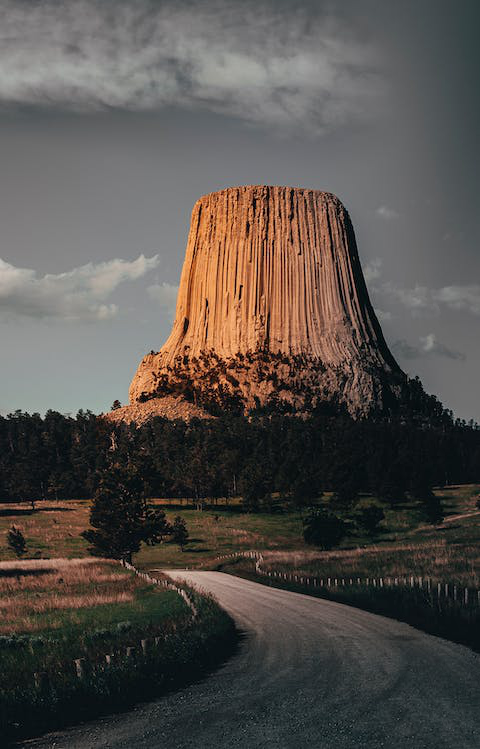

In [292]:
print(width,height)
showImage(img_t,width,height)

## CPU calculate and Compare to GPU

In [127]:
from skimage.metrics import mean_squared_error, structural_similarity

def image_difference(image1, image2):
    mse = mean_squared_error(image1, image2)
    ssim = structural_similarity(image1, image2)
    return mse, ssim

In [186]:
def convert_Rgb2Gray_host(inPixels, width, height):
    outPixels = []

    # gray = 0.299*red + 0.587*green + 0.114*blue
    for r in range(height):
        for c in range(width):
            i = r * width + c
            gray_value = round((0.299 * inPixels[i][0] + 0.587 * inPixels[i][1] + 0.114 * inPixels[i][2]),3)
            outPixels.append([gray_value, gray_value, gray_value])

    return outPixels

def detect_edges(in_pixels, width, height):
  filter_width = 3
  x_sobel_filter = [1, 0, -1, 2, 0, -2, 1, 0, -1] # Bộ lọc Sobel theo trục x
  y_sobel_filter = [1, 2, 1, 0, 0, 0, -1, -2, -1] # Bộ lọc Sobel theo trục y

  out_pixels = []

  for out_pixels_r in range(height):
      for out_pixels_c in range(width):
          x_sobel_pixel = 0
          y_sobel_pixel = 0

          for filter_r in range(filter_width):
              for filter_c in range(filter_width):
                  x_sobel_filter_val = x_sobel_filter[filter_r * filter_width + filter_c]
                  y_sobel_filter_val = y_sobel_filter[filter_r * filter_width + filter_c]

                  in_pixels_r = out_pixels_r - filter_width // 2 + filter_r
                  in_pixels_c = out_pixels_c - filter_width // 2 + filter_c

                  in_pixels_r = min(max(0, in_pixels_r), height - 1)
                  in_pixels_c = min(max(0, in_pixels_c), width - 1)

                  in_pixel = in_pixels[in_pixels_r * width + in_pixels_c]

                  x_sobel_pixel += x_sobel_filter_val * in_pixel[0]
                  y_sobel_pixel += y_sobel_filter_val * in_pixel[0]

          detect_value = abs(x_sobel_pixel) + abs(y_sobel_pixel)

          out_pixels.append(detect_value)

  return out_pixels


def get_least_importance_pixels_cpu(in_pixels, width, height):
    out_pixels = [0] * (width * height)

    for c in range(width):
        index = (height - 1) * width + c
        out_pixels[index] = in_pixels[index] # giữ nguyên kết quả hàng cuối cùng

    for r in range(height - 2, -1, -1): # duyệt từng hàng từ dưới lên
        for c in range(width):
            index = r * width + c

            if c == 0: # Trường hợp vị trí pixel ở cột đầu tiên
                min_val = min(out_pixels[index + width], out_pixels[index + width + 1])
                min_val += in_pixels[index]
                out_pixels[index] = min_val
                continue

            if c == width - 1: # Trường hợp vị trí pixel ở cột cuối cùng
                min_val = min(out_pixels[index + width], out_pixels[index + width - 1])
                min_val += in_pixels[index]
                out_pixels[index] = min_val
                continue

            # Tìm min cho pixel đang duyệt
            min_val = min(out_pixels[index + width], out_pixels[index + width + 1], out_pixels[index + width - 1])
            min_val += in_pixels[index]
            out_pixels[index] = min_val

    return out_pixels



def find_seam(in_pixels, width, height):
    path_seam = [0] * height

    min_val = in_pixels[0]
    index = 0
    path_seam[0] = index


    for c in range(width): # duyệt để tìm Pixel trong hàng đầu tiên có độ quan trọng thấp nhất
        if in_pixels[c] < min_val:
            min_val = in_pixels[c]
            index = c

    path_seam[0] = index

    for r in range(1, height):
        if index % width == 0:
            if in_pixels[index + width] <= in_pixels[index + width + 1]:
                path_seam[r] = index + width
                index = index + width
            else:
                path_seam[r] = index + width + 1
                index = index + width + 1
            continue

        if index % width == (width - 1):
            if in_pixels[index + width] <= in_pixels[index + width - 1]:
                path_seam[r] = index + width
                index = index + width
            else:
                path_seam[r] = index + width - 1
                index = index + width - 1
            continue

        location = index + width - 1
        min_val = in_pixels[index + width - 1]
        path_seam[r] = index + width - 1

        if in_pixels[index + width] < min_val:
            min_val = in_pixels[index + width]
            path_seam[r] = index + width
            location = index + width

        if in_pixels[index + width + 1] < min_val:
            path_seam[r] = index + width + 1
            location = index + width + 1

        index = location

    return path_seam


def remove_pixels(in_pixels, width, height, seam_path):
  index_seam = 0
  out_pixels = []
  for r in range(height):
    for c in range(width):
      index = r * width + c

      if (index_seam < height) and (index == seam_path[index_seam]):
        index_seam += 1
      else:
        out_pixels.append(in_pixels[index])
  width -= 1
  return out_pixels, width, height

In [282]:
# ----------------- HOST -------------------
inPixels, width, height = getImage(pathFile)

# Gray scale
start = time.time()
grayPixels = convert_Rgb2Gray_host(inPixels, width, height)
print("Time taken: %ss" % (round(time.time() - start,5)))

# detect edges
importancePixels = detect_edges(grayPixels, width, height)

# get_least_importance_pixels
get_least_importance_pixels = get_least_importance_pixels_cpu(importancePixels, width, height)


# Get path seam
pathSeam = find_seam(get_least_importance_pixels, width, height)


Time taken: 7.14531s


In [283]:

output_array_host = np.array([lst[len(lst) // 2] for lst in grayPixels]).reshape(height,width) # host
output_array_device = out.reshape(height,width) # GPU

# Example usage to compare GrayScale images between using CPU and GPU


# ------- Gray Scale -------
image1 = output_array_device  # First image (numpy array or PIL image)
image2 = output_array_host  # Second image (numpy array or PIL image)

mse, ssim = image_difference(image1, image2)
print("------- Gray Scale -------")
print("Mean Squared Error:", mse)
print("Structural Similarity Index:", ssim)


# ------- Detection Edge -------
image1 = np.array(importancePixels, dtype=np.float32).reshape(height,width)  # CPU
image2 = importancePixels_gpu.reshape(height,width)  # Second image (numpy array or PIL image)

mse, ssim = image_difference(image1, image2)
print("------- Detection Edge -------")
print("Mean Squared Error:", mse)
print("Structural Similarity Index:", ssim)


def calculate_mrse(array1, array2):
    error = np.sqrt(np.mean((array1 - array2)**2))
    return error

# ------- MRSE --------
mrse = calculate_mrse(np.array(get_least_importance_pixels).reshape(height,width), least_importance_pixel_cuda.reshape(height,width))
print("--------- least_importance_pixels ----------")
print("MRSE:", mrse)


------- Gray Scale -------
Mean Squared Error: 7.213527321465462e-29
Structural Similarity Index: 0.9999999999758832
------- Detection Edge -------
Mean Squared Error: 8.879081319141446e-30
Structural Similarity Index: 1.0000000000019487
--------- least_importance_pixels ----------
MRSE: 0.002179420403287091
